In [1]:
#purpose is to take HST images and identify extended sources (HH objects in our case)

#just to check python version - should be 3.7.4
from platform import python_version
print(python_version())

#importing astro libraries
from astropy.io import fits
from astropy.convolution import convolve, Gaussian2DKernel, Box2DKernel
from astropy.nddata import Cutout2D
from astropy.wcs import WCS

#importing general tools
import glob
import itertools
import matplotlib 
matplotlib.use('Agg') #invokved b/c just plain matplotlib was insufficient
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys

%matplotlib inline

3.8.13


C:\Users\arubi\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# #finding the path to every fits images in a directory
def im_name_finder(path, file_type):
    #Using glob (it's a unix command similar to ls)
    #WARNING: using recursive=True...depending how many images you use this could be very slow, it's recommended not to have too many subfolders
    #if needed, some example code is commented towards the latter half of this code that could help make an alternative
    all_names = glob.glob(path, recursive=True)

    #IMPORTANT: Using "fit" here because it is inclusive of both fits and FIT...some files end in "FIT" and need to be included
    #using s.lower() include uppercase names
    im_names = [s for s in all_names if 'fit' in s.lower()]

    return im_names

# In[27]:

#setting up a new fits file to be saved and viewed in DS9
#primarily to save the image we reprojected, but can also be used to save the convolved images
def fits_saver(array, wcs_header, name, save_path):
    '''
    array is a 2d array of data - could be from reprojecting one image onto another or from convolution
    wcs_header is a header containing the wcs coords of the image that we projected onto or of the orig image (if from the convolution)
    name is the path to some image you're using. It will get string split at the / character, and the func only takes the last element of that splitting
    save_path is the folder you want to save to...recommended to also add something to the start of the images names to make it clear what you did to them (e.g. 'Regridded/regrid_')
    '''

    #creating a new file and adding the reprojected array of data as well as the WCS that we projected onto
    hdu_new = fits.PrimaryHDU(array, header=wcs_header)
    hdul = fits.HDUList([hdu_new])
    
    #saving the file
    if name.find('FIT') == -1: #needed if file end incorrect
        new_filename = name.split('/')[-1]  #grabs the file name we were using from before
        hdul.writeto(save_path+new_filename, overwrite=True)
    else:
        name_fixfit = name[:-3] + 'fits'
        new_filename = name_fixfit.split('/')[-1]  #grabs the file name we were using from before
        hdul.writeto(save_path+new_filename, overwrite=True)
        
    return (save_path+new_filename)

# Gather some data, convert units!

In [3]:
# path = '../../Montage_results/n2071_headercut/*drz.fits' # #using ** will grab all files even in subdirectories WARNING takes longer
# im_names_n2071 = sorted(im_name_finder(path, 'fit')) #im_finder is basically glob.glob
# im_names_n2071 = [i.replace('\\', '/') for i in im_names_n2071]
im_names_n2071 = ['../scaling_for_motions/160_epoch1_scaled.fits', '../scaling_for_motions/160_epoch2_synth_scaled.fits']

print(im_names_n2071)

# path = '../../Montage_results/n2071_headercut/*drz.fits' # #using ** will grab all files even in subdirectories WARNING takes longer
# im_names_n2071 = sorted(im_name_finder(path, 'fit')) #im_finder is basically glob.glob
# im_names_n2071 = [i.replace('\\', '/') for i in im_names_n2071]
# print(im_names_n2071)

hdu_list = [fits.open(i) for i in im_names_n2071]

#initializing some lists to be used
hdu_pix_list = []
hdu_pixtorad_list = []
# hdu_fnu_list = []
hdu_lam_list = []
# hdu_flam_list = []
# hdu_bw_list = []
hdu_data_list = []
hdu_header_list = []

count = 0
for hdu_data in hdu_list:   
    #reading in data for general use  and header for wcs
    #converting by times by flam * bw from e-/sec...should get units of erg/cm^2/sec as above
    hdu_data_list.append(hdu_data[0].data) # * hdu_list[0].header['PHOTFLAM'] * hdu_list[0].header['PHOTBW'])
    hdu_header_list.append(hdu_data[0].header)
    
    count+=1

['../scaling_for_motions/160_epoch1_scaled.fits', '../scaling_for_motions/160_epoch2_synth_scaled.fits']


# Inspecting the data files to check how the headers work

In [8]:
print(hdu_data_list[-1])

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


# Next, try to identify some HH objects...
This is tricky. We'll need photutils, segmentation maps, a cutout of the image, maybe smoothing the image by convolution...

In [10]:
#installing any needed packages if you want to do photometry and segmentation (we do!)
# !conda install --yes --prefix {sys.prefix} -c conda-forge photutils

In [4]:
from photutils.background import Background2D, MedianBackground
from photutils.segmentation import detect_threshold

from astropy.convolution import Gaussian2DKernel, convolve
from astropy.stats import gaussian_fwhm_to_sigma
from photutils.segmentation import detect_threshold, detect_sources
from photutils.segmentation import deblend_sources

from photutils.segmentation import SourceCatalog

  0%|          | 0/26 [00:00<?, ?it/s]

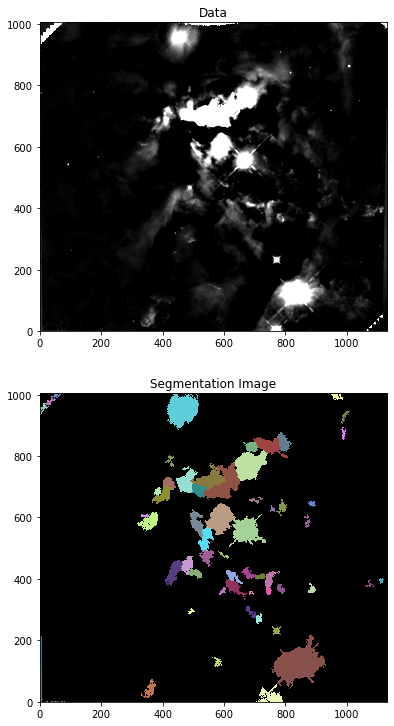

In [6]:
#this set of cells shows how to apply our procedure to an entire large mosaic image

#first step is background subtraction, thresholding
#I've found better to use no background subtracting, but the option is there if you like

#please see https://photutils.readthedocs.io/en/stable/segmentation.html for references and documentation
#the idea is to use the photutils package and/or segmentation maps to distinguish a bright source from background or noise

from photutils.background import Background2D, MedianBackground
from photutils.segmentation import detect_threshold
bkg_estimator = MedianBackground()

bkg_list = []
data_bkg_subtracted = []
threshold_list = []
nsig = 1. #IMPORTANT, should change this...
for data in [hdu_data_list[0]]:
#     data_cut = np.array(hdu_data_list[-1][2700:3000, 4500:4900])
    data_cut = data
    bkg = Background2D(data_cut, (50, 50), filter_size=(3, 3), bkg_estimator=bkg_estimator)
    bkg_list.append(bkg)
#     threshold_list.append(2. * bkg.background_rms )  # above the background
    threshold_list = detect_threshold(data_cut, nsigma=nsig)
    data_bkg_subtracted.append( data_cut - bkg.background ) # subtract the background
    
    #next we apply segmentation maps
from astropy.convolution import Gaussian2DKernel, convolve
from astropy.stats import gaussian_fwhm_to_sigma
from photutils.segmentation import detect_threshold, detect_sources
from photutils.segmentation import deblend_sources

sigma = nsig * gaussian_fwhm_to_sigma  # FWHM = whatever number is in front
kernel = Gaussian2DKernel(sigma, x_size=nsig, y_size=nsig)
kernel.normalize()

npixels = 150
segm_deblend_list = []
# convolved_list = [] #if you would like to convolve data
for (data,threshold) in zip(data_bkg_subtracted, threshold_list):
#     convolved_list.append( convolve(data, kernel, normalize_kernel=True) )
    segm = detect_sources(data, threshold, npixels=npixels)
    segm_deblend_list. append( deblend_sources(data, segm, npixels=npixels, nlevels=32, contrast=0.001) )
    
    
from photutils.segmentation import SourceCatalog

cat_list = []
for (data, segm_deblend) in zip(data_bkg_subtracted, segm_deblend_list): 
    cat_list.append( SourceCatalog(data, segm_deblend) )
#     tbl = cat.to_table()
#     tbl['xcentroid'].info.format = '.2f'  # optional format
#     tbl['ycentroid'].info.format = '.2f'
#     tbl['kron_flux'].info.format = '.2f'
#     print(tbl)



#finally we plot the image, the segments, and also show you can automatically produce naive apertures
from astropy.visualization import simple_norm

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.set_title('Data')
ax2.set_title('Segmentation Image')

img_choice = [0] #enabling you to choose your image, should be adjustable to needs
for i in img_choice:
    apertures = cat_list[i].kron_aperture
    patches = []
    
    #plotting apertures
#     for aperture in apertures:
#         #filtering apertures by size, could do it by flux, called aperture.kron_flux
#         if aperture is not None and np.pi*aperture.a*aperture.b > 500 and np.pi*aperture.a*aperture.b < 2000:
#             aperture.plot(axes=ax1, color='white', lw=1.5)
#             aperture.plot(axes=ax2, color='white', lw=1.5)
#             patches.append(aperture._to_patch())
    
    #plotting the thresholded data
    norm = simple_norm(data_bkg_subtracted[i], 'sqrt')
    ax1.imshow(data_bkg_subtracted[i], origin='lower', cmap='Greys_r', vmin=0, vmax=0.0001)
    
    #plotting the associated segmentation map
    cmap = segm_deblend_list[i].make_cmap(seed=123)
    ax2.imshow(segm_deblend_list[i], origin='lower', cmap=cmap, interpolation='nearest')

  0%|          | 0/23 [00:00<?, ?it/s]

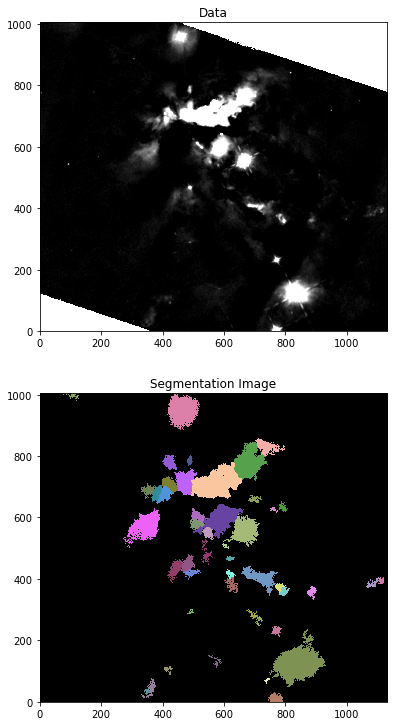

In [16]:
#this set of cells shows how to apply our procedure to an entire large mosaic image

#first step is background subtraction, thresholding
#I've found better to use no background subtracting, but the option is there if you like

#please see https://photutils.readthedocs.io/en/stable/segmentation.html for references and documentation
#the idea is to use the photutils package and/or segmentation maps to distinguish a bright source from background or noise

from photutils.background import Background2D, MedianBackground
from photutils.segmentation import detect_threshold
bkg_estimator = MedianBackground()

bkg_list = []
data_bkg_subtracted = []
threshold_list = []
nsig = 1. #IMPORTANT, should change this...
for data in [hdu_data_list[1]]:
#     data_cut = np.array(hdu_data_list[-1][2700:3000, 4500:4900])
    data_cut = data
    bkg = Background2D(data_cut, (50, 50), filter_size=(3, 3), bkg_estimator=bkg_estimator)
    bkg_list.append(bkg)
#     threshold_list.append(2. * bkg.background_rms )  # above the background
    threshold_list = detect_threshold(data_cut, nsigma=nsig)
    data_bkg_subtracted.append( data_cut - bkg.background ) # subtract the background
    
    #next we apply segmentation maps
from astropy.convolution import Gaussian2DKernel, convolve
from astropy.stats import gaussian_fwhm_to_sigma
from photutils.segmentation import detect_threshold, detect_sources
from photutils.segmentation import deblend_sources

sigma = nsig * gaussian_fwhm_to_sigma  # FWHM = whatever number is in front
kernel = Gaussian2DKernel(sigma, x_size=nsig, y_size=nsig)
kernel.normalize()

npixels = 150
segm_deblend_list = []
# convolved_list = [] #if you would like to convolve data
for (data,threshold) in zip(data_bkg_subtracted, threshold_list):
#     convolved_list.append( convolve(data, kernel, normalize_kernel=True) )
    segm = detect_sources(data, threshold, npixels=npixels)
    segm_deblend_list. append( deblend_sources(data, segm, npixels=npixels, nlevels=32, contrast=0.001) )
    
    
from photutils.segmentation import SourceCatalog

cat_list = []
for (data, segm_deblend) in zip(data_bkg_subtracted, segm_deblend_list): 
    cat_list.append( SourceCatalog(data, segm_deblend) )
#     tbl = cat.to_table()
#     tbl['xcentroid'].info.format = '.2f'  # optional format
#     tbl['ycentroid'].info.format = '.2f'
#     tbl['kron_flux'].info.format = '.2f'
#     print(tbl)



#finally we plot the image, the segments, and also show you can automatically produce naive apertures
from astropy.visualization import simple_norm

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.set_title('Data')
ax2.set_title('Segmentation Image')

img_choice = [0] #enabling you to choose your image, should be adjustable to needs
for i in img_choice:
    apertures = cat_list[i].kron_aperture
    patches = []
    
    #plotting apertures
#     for aperture in apertures:
#         #filtering apertures by size, could do it by flux, called aperture.kron_flux
#         if aperture is not None and np.pi*aperture.a*aperture.b > 500 and np.pi*aperture.a*aperture.b < 2000:
#             aperture.plot(axes=ax1, color='white', lw=1.5)
#             aperture.plot(axes=ax2, color='white', lw=1.5)
#             patches.append(aperture._to_patch())
    
    #plotting the thresholded data
    norm = simple_norm(data_bkg_subtracted[i], 'sqrt')
    ax1.imshow(data_bkg_subtracted[i], origin='lower', cmap='Greys_r', vmin=0, vmax=0.0001)
    
    #plotting the associated segmentation map
    cmap = segm_deblend_list[i].make_cmap(seed=123)
    ax2.imshow(segm_deblend_list[i], origin='lower', cmap=cmap, interpolation='nearest')

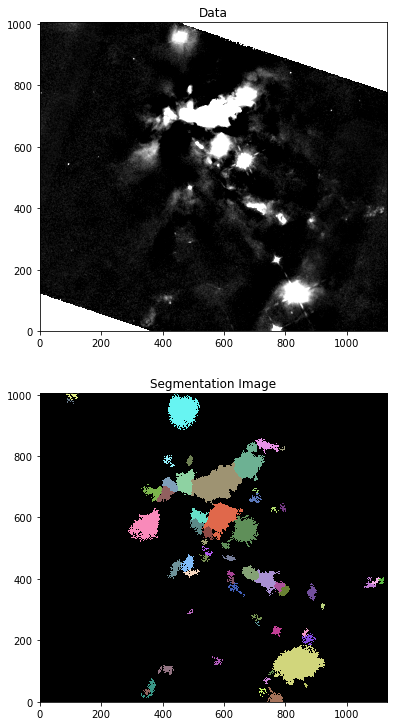

In [53]:
#trying to only show mask

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.set_title('Data')
ax2.set_title('Segmentation Image')

norm = simple_norm(data_bkg_subtracted[i], 'sqrt')
ax1.imshow(data_bkg_subtracted[i], origin='lower', cmap='Greys_r', vmin=-1e-18, vmax=3e-17)

cmap = segm_deblend_list[i].make_cmap(seed=123)
ax2.imshow(segm_deblend_list[i], origin='lower', cmap=cmap, interpolation='nearest')
fig.savefig('ngc2071_segmented.png', dpi=1000)

# Maybe pick a specific HH object, zooming in...

In [ ]:
#now to refine this method on a specific HH object
#here I choose HH 6, relatively bright but also many difficulties like poor alignment and few stars
#from here on, trying to do all the steps at once for convenience since they're all required

#please see https://photutils.readthedocs.io/en/stable/segmentation.html for references and documentation
#the idea is to use the photutils package and/or segmentation maps to distinguish a bright source from background or noise

#first, refine the data with thresholding, background subtraction, etc
bkg_estimator = MedianBackground()

bkg_list = []
data_bkg_subtracted = []
threshold_list = []
nsig = 1. #IMPORTANT, should change this...
for data in hdu_data_list[-1:]: 
    data_cut = np.array(hdu_data_list[-1][2700:3000, 4500:4900])
    
    bkg = Background2D(data_cut, (50, 50), filter_size=(3, 3), bkg_estimator=bkg_estimator)
    bkg_list.append(bkg)
#     threshold_list.append(2. * bkg.background_rms )  # above the background
    threshold_list = detect_threshold(data_cut, nsigma=nsig)
    data_bkg_subtracted.append( data_cut - bkg.background ) # subtract the background

    
#now applying segmentation
sigma = nsig * gaussian_fwhm_to_sigma  # FWHM = whatever number is in front
kernel = Gaussian2DKernel(sigma, x_size=nsig, y_size=nsig)
kernel.normalize()

npixels = 17
segm_deblend_list = []
# convolved_list = []
for (data,threshold) in zip(data_bkg_subtracted, threshold_list):
    print(type(data))
#     convolved_list.append( convolve(data, kernel, normalize_kernel=True) )
    segm = detect_sources(data, threshold, npixels=npixels)
    segm_deblend_list.append(deblend_sources(data, segm, npixels=npixels, nlevels=32, contrast=0.001) )

    
#locating and outputting centroids for convenience or checking if needed
cat_list = []
for (data, segm_deblend) in zip(data_bkg_subtracted, segm_deblend_list): 
    cat_list.append( SourceCatalog(data, segm_deblend) )
    tbl = cat_list[0].to_table()
    tbl['xcentroid'].info.format = '.2f'  # optional format
    tbl['ycentroid'].info.format = '.2f'
    tbl['kron_flux'].info.format = '.2f'
    print(tbl)


#plotting the data and segmentation image
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.set_title('Data')
ax2.set_title('Segmentation Image')

img_choice = [0]
for i in img_choice:
    apertures = cat_list[0].kron_aperture
    patches = []
    for count, aperture in enumerate(apertures):
        if aperture is not None:
            aperture.plot(axes=ax1, color='white', lw=1.5)
            aperture.plot(axes=ax2, color='white', lw=1.5)
            patches.append(aperture._to_patch())
    
    #plotting the thresholded data
    norm = simple_norm(data_bkg_subtracted[0], 'sqrt')
    ax1.imshow(data_bkg_subtracted[0], origin='lower', cmap='Greys_r', vmin=-1e-18, vmax=3e-17)
    
    #plotting the associated map of segments
    cmap = segm_deblend_list[0].make_cmap(seed=123)
    ax2.imshow(segm_deblend_list[0], origin='lower', cmap=cmap, interpolation='nearest')

# Maybe try convolving the data to smooth it?

In [54]:
#we require a function to convolve the data...
def im_conv(low_res_name, D, hdu_pix_torad, hdu_dat, kern):
    #unfortuantely no good way to find wavelength from header right now. can enter it manually, but I tried to automate it

    #reading in excel file of wavelengths...right now needs to be in same directory as this code
    #first col is a substring of the fits image file name, the second col is the wavelengths in microns
    df = pd.read_excel('imglams.xlsx')
    cols = df.columns
    cols_str = [str(i) for i in df[cols[0]]]
    #some test cases I was using

    #gaussian kernel
    if kern == 'gauss':
        #this finds the loc in the excel file where the image substring matches our image name
        #it then finds the wavelength value corresponding to that loc
        lam =  df.loc[np.where([i in low_res_name for i in cols_str])[0][0]].values[1] #lambda in microns

        #finding angular resolution...the FWHM of our Gaussian PSF
        res = 1.2 * lam / D         #resolution in radians
        res = res / hdu_pix_torad        #so converting to pixels

        #finding PSF and then calculating the convolution of our image and the PSF of the image we're projecting onto
        kernel = Gaussian2DKernel(res)

    #box kernel
    if kern == 'box':
        kernel = Box2DKernel(16.)

    hdu_conv = convolve(hdu_dat, kernel)
    return hdu_conv

<class 'numpy.ndarray'>


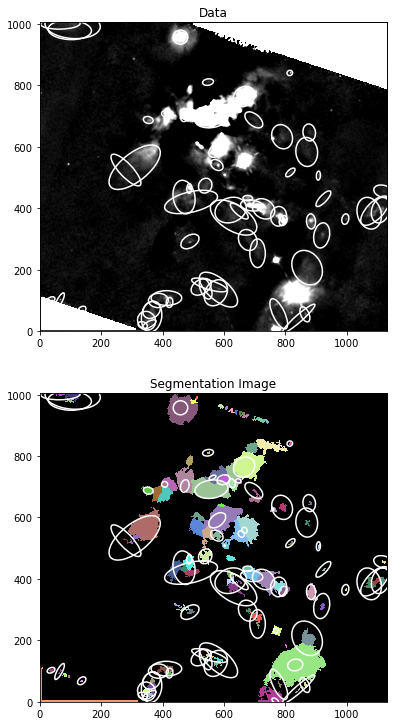

In [56]:
#tests on convolved data

#testing on cutouts
#please see https://photutils.readthedocs.io/en/stable/segmentation.html for references and documentation
#the idea is to use the photutils package and/or segmentation maps to distinguish a bright source from background or noise

#first step is thresholding, trying background subtraction, remember to change nsig used for thresholding
bkg_estimator = MedianBackground()

bkg_list = []
data_bkg_subtracted = []
threshold_list = []
nsig = 1. #IMPORTANT, should change this...
D = 2.4 * 1e6 #m to microns for hubble, mic is unit of wavelength file
for data in [hdu_data_list[0]]: 
    data_cut = np.array(hdu_data_list[0])
    hdu_im_conv = im_conv(im_names_n2071[0], D, 5.817764e-7, data_cut, 'gauss')
#     hdu_im_conv = im_conv('164_dash', D, hdu_pixtorad_list[-1], hdu_im_conv, 'gauss')
    
    bkg = Background2D(hdu_im_conv, (50, 50), filter_size=(3, 3), bkg_estimator=bkg_estimator)
    bkg_list.append(bkg)
#     threshold_list.append(2. * bkg.background_rms )  # above the background
    threshold_list = detect_threshold(hdu_im_conv, nsigma=nsig)
    data_bkg_subtracted.append( hdu_im_conv - bkg.background ) # subtract the background


#and again, we segment the image...remember to adjust npixels included in a given segment
sigma = nsig * gaussian_fwhm_to_sigma  # FWHM = whatever number is in front
kernel = Gaussian2DKernel(sigma, x_size=nsig, y_size=nsig)
kernel.normalize()

npixels = 60 #here, change this!
segm_deblend_list = []
# convolved_list = []
for (data,threshold) in zip(data_bkg_subtracted, threshold_list):
    print(type(data))
#     convolved_list.append( convolve(data, kernel, normalize_kernel=True) )
    segm = detect_sources(data, threshold, npixels=npixels)
    segm_deblend_list.append(deblend_sources(data, segm, npixels=npixels, nlevels=32, contrast=0.001) )

    
#locating and outputting centroids for convenience or checking if needed
cat_list = []
for (data, segm_deblend) in zip(data_bkg_subtracted, segm_deblend_list): 
    cat_list.append( SourceCatalog(data, segm_deblend) )
#     tbl = cat.to_table()
#     tbl['xcentroid'].info.format = '.2f'  # optional format
#     tbl['ycentroid'].info.format = '.2f'
#     tbl['kron_flux'].info.format = '.2f'
#     print(tbl)


#plotting the data and segmentation image
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.set_title('Data')
ax2.set_title('Segmentation Image')

img_choice = [0]
for i in img_choice:
    apertures = cat_list[0].kron_aperture
    patches = []
    for count, aperture in enumerate(apertures):
        if aperture is not None:
            aperture.plot(axes=ax1, color='white', lw=1.5)
            aperture.plot(axes=ax2, color='white', lw=1.5)
            patches.append(aperture._to_patch())
            
    #plotting the thresholded data
    norm = simple_norm(data_bkg_subtracted[0], 'sqrt')
    ax1.imshow(data_bkg_subtracted[0], origin='lower', cmap='Greys_r', vmin=-1e-18, vmax=3e-17)
    
    #plotting the associated map of segments
    cmap = segm_deblend_list[0].make_cmap(seed=123)
    ax2.imshow(segm_deblend_list[0], origin='lower', cmap=cmap, interpolation='nearest')

# Not bad! Let's check by hand what we want and then plot some stats

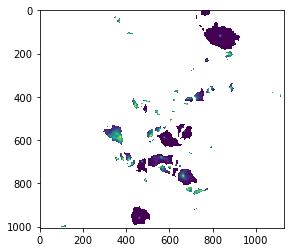

In [59]:
'''
we want to exclude some segments that are either error-prone or not related to our object of interest. 
how do we do that?

there are a few options for locating segments of the map
one is via snr ratios
another is using kron apertures auto-calculated here with photutils
yet another is just doing it by hand and coloring things differently

#experimenting of finding way that includes the entire masked region of interest as opposed to using kron apertures

print(dir(segm_deblend_list[0].segments))
plt.imshow(np.flip(data_bkg_subtracted[0] [segm_deblend_list[0].segments[5].slices ], axis=0) )
print(np.sum(data_bkg_subtracted[0] [segm_deblend_list[0].segments[5].slices ])) #calculating flux from bbox
'''

#composing list of color maps
import matplotlib.patches as mpatches
cmap_list = ['', 'Greens', 'copper', 'cividis', 'Blues', 'BrBG', 'Greys', 'pink', 
             'Oranges', 'Greys', 'magma', 'summer', 'winter', 'bone', 
            'Purples', 'hot', 'cool', 'plasma', 'spring']
#so the ones that I'm excluding are label = 6 and label = 8

#looping through segments
for i in segm_deblend_list[0].labels:
    segm_nparr = np.array(segm_deblend_list[0])  #this is the list of segments 
    segm_nparr[segm_nparr != i] = 0 #filtering out segments aside from our chosen labeled segment
    data_masked = np.ma.masked_array(data_bkg_subtracted[0], mask=segm_nparr) #masking the data using segm_nparr
    mask=np.ma.getmask(data_masked) #we need to invert the mask, so we grab it
    data_masked = np.ma.masked_array(data_bkg_subtracted[0], mask=~mask) #then we invert it
    im = plt.imshow(data_masked)#, cmap=cmap_list[i])

In [60]:
#quick empirical CDF function
#if I want confidence intervals, can update using https://james-brennan.github.io/posts/edf/
def edf_calc(data):
    x0 = data.min() # get sample space
    x1 = data.max()
    x = np.linspace(x0, x1, 100) 
    N = data.size # number of observations
    y = np.zeros_like(x)
    for i, xx in enumerate(x):
        # sum the vectorised indicator function 
        y[i] = np.sum(data <= xx)/N 
    return x, y
#     x = np.sort(data)
#     n = x.size
#     y = np.arange(1, n+1) / (n)
    
#     #alt method from https://stackoverflow.com/questions/42147206/normalizing-cdf-in-python
#     num_bins = 2500
#     x = data[~np.isnan(np.sort(data))]
#     counts, bin_edges = np.histogram(x, bins=num_bins, range=(np.nanmin(x), np.nanmax(x)), density=True)
#     center = (bin_edges[:-1] + bin_edges[1:]) / 2
    
#     # Calculate and plot CDF of sample 
#     cdf = np.cumsum(counts)
#     scale = 1.0/cdf[-1]
#     norm_cdf = scale * cdf
    
#     return(center, norm_cdf)


C:\Users\arubi\anaconda3\lib\site-packages\IPython\core\events.py:89: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  func(*args, **kwargs)
C:\Users\arubi\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


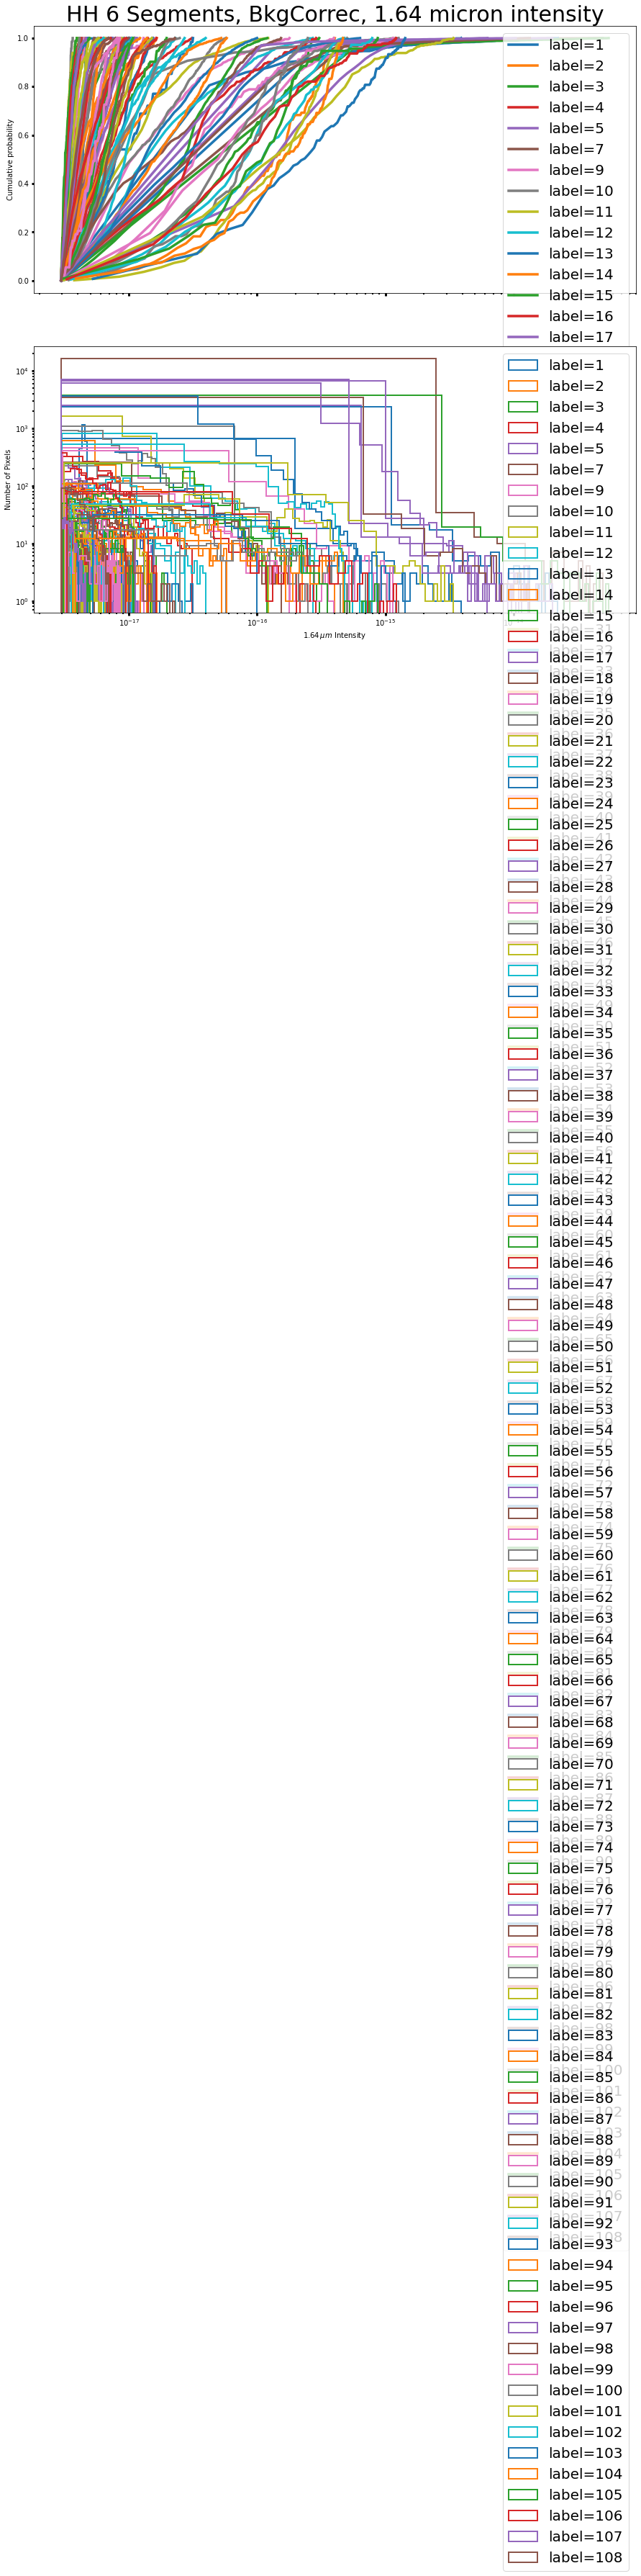

In [61]:
#need to implement as line ratios...
#testing histograms and eCDFs because we want to know whether the distributions of pixel intensity look reasonable

#need to set up figures...
fig, (ax1, ax2) = plt.subplots(2, figsize=(15,15), sharex=True, constrained_layout=True)
# fig.suptitle('Fe[II] Line Ratios of Herbig-Haro Objects')


#plot formatting
#from https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot
SMALL_SIZE = 8
MEDIUM_SIZE = 20
BIGGER_SIZE = 25

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
ax1.tick_params(axis='both', which='major', width=3)
ax1.tick_params(axis='both', which='minor', width=2)
ax2.tick_params(axis='both', which='major', width=3)
ax2.tick_params(axis='both', which='minor', width=2)


from cycler import cycler
plt.rc('axes', prop_cycle=(cycler('color', ['green', 'black', 'gray', 'blue', 'brown', 'chocolate', 'salmon',
                                           'darkorange', 'gold', 'khaki', 'teal', 'powderblue', 'steelblue',
                                           'darkviolet', 'plum', 'magenta', 'deeppink', 'pink'])))

#looping through segments
for i in range(len(segm_deblend_list[0].labels)):
    label_val = segm_deblend_list[0].labels[i]
    
    #exclude segments from above cell found we don't care about
    if label_val != 6 and label_val != 8:
        segm_nparr = np.array(segm_deblend_list[0])  #this is the list of segments 
        segm_nparr[segm_nparr != label_val] = 0 #filtering out segments aside from our chosen labeled segment
        data_masked = np.ma.masked_array(data_bkg_subtracted[0], mask=segm_nparr) #masking the data using segm_nparr
        mask=np.ma.getmask(data_masked) #we need to invert the mask, so we grab it
        data_masked = np.ma.masked_array(data_bkg_subtracted[0], mask=~mask) #then we invert it

        xedf, yedf = edf_calc(data_masked[data_masked.mask == False])
        plot_color = ax1.plot(xedf, yedf, label =  'label='+str(label_val), linewidth = 3.5, linestyle='-')
        n, bins, patches = ax2.hist(data_masked[data_masked.mask == False], label = 'label='+str(label_val), density=False, histtype ='step', bins=20, linewidth=2)  # density=False would make counts

ax1.set_title('HH 6 Segments, BkgCorrec, 1.64 micron intensity')
ax1.set_ylabel('Cumulative probability')
ax1.legend()
ax1.set_xscale('log')

ax2.set_yscale('log')
ax2.set_ylabel('Number of Pixels')
ax2.set_xlabel(r'$1.64 \, \mu m$ Intensity')
ax2.legend(loc='upper right')
# plt.xlim(1e-17, 1e-16)

# Can we do better?
Of course! We can try this:

-without the background subtraction or with a different background subtraction to preserve more of the data

-trying to add some high-resolution images of similar wavelengths together

-maybe further adjustments to npixels and nsigma accordingly

In [ ]:
#what if we have more than one filter at high-resolution? typically wouldn't do this but let's try...
#-> segmentation map of rgb image using  photutils or skimage

#splitting data into rgb channels...shifting in case we wanna look at a different cutout
#tried to order images from largest to smallest wavelength as r to b
xshift_r = 0
yshift_r = 0
yshift_g = 0
yshift_b = 0
r = np.flip(hdu_data_list[-1][2700+xshift_r:3000+xshift_r, 4500+yshift_r:4900+yshift_r], axis=0)
g = np.flip(hdu_data_list[-2][2700:3000, 4500+yshift_g:4900+yshift_g], axis=0)
b = np.flip(hdu_data_list[-3][2700:3000, 4500+yshift_b:4900+yshift_b], axis=0)



#turning this all into an rgb image format *PURELY FOR DISPLAY PURPOSES*
from astropy.visualization import make_lupton_rgb
#see https://stackoverflow.com/questions/61179993/getting-a-dark-image-using-make-lupton-rgb for plotting vals
lo_val, up_val = np.percentile(np.hstack((r.flatten(), g.flatten(), b.flatten())), (0.5, 99.5))  # Get the value of lower and upper 0.5% of all pixels
stretch_val = up_val - lo_val
orig_rgb = make_lupton_rgb(r, g, b, minimum=lo_val, stretch=stretch_val, Q=0)
#plt.imshow(image) #output
# print(image)

#here I just take the direct sum for my grayscale image
#this is uniform weight, but you could weight it differently (real life rgb is completely different)
grayscale = r+g+b

#plotting the rgb image and grayscale data
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax = axes.ravel()

ax[0].imshow(orig_rgb)
ax[0].set_title("RGB")
ax[1].imshow(grayscale, cmap=plt.cm.gray, vmin=1e-18, vmax=5e-17)
ax[1].set_title("Grayscale")

fig.tight_layout()
plt.show()


#now taking gray scale image and trying out the segmentation map on it

#please see https://photutils.readthedocs.io/en/stable/segmentation.html for references and documentation
#the idea is to use the photutils package and/or segmentation maps to distinguish a bright source from background or noise

#first step is thresholding, here I commented at background correction, overall seems fine without it but you might need it
#remember to change nsig used for thresholding
bkg_estimator = MedianBackground()

bkg_list = []
data_bkg_subtracted = []
threshold_list = []
nsig = 2. #IMPORTANT, should change this...

for data in [grayscale]: 
    data_cut = np.flip(data, axis=0)
    hdu_im_conv = im_conv('164_dash', D, hdu_pixtorad_list[-1], data_cut, 'gauss')

    
    bkg = Background2D(hdu_im_conv, (50, 50), filter_size=(3, 3), bkg_estimator=bkg_estimator)
    bkg_list.append(bkg)
#     threshold_list.append(2. * bkg.background_rms )  # above the background
    threshold_list = detect_threshold(hdu_im_conv, nsigma=nsig)
    data_bkg_subtracted.append( hdu_im_conv) #- bkg.background ) # subtract the background


#next we segment the image, remember to change the required number of pixels, npixels, you want in eahc segment
sigma = nsig * gaussian_fwhm_to_sigma  # FWHM = whatever number is in front
kernel = Gaussian2DKernel(sigma, x_size=nsig, y_size=nsig)
kernel.normalize()

npixels = 90
segm_deblend_list = []
# convolved_list = []
for (data,threshold) in zip(data_bkg_subtracted, threshold_list):
    print(type(data))
#     convolved_list.append( convolve(data, kernel, normalize_kernel=True) )
    segm = detect_sources(data, threshold, npixels=npixels)
    segm_deblend_list.append(deblend_sources(data, segm, npixels=npixels, nlevels=32, contrast=1e-3) )


#noting centroids for reference
cat_list = []
for (data, segm_deblend) in zip(data_bkg_subtracted, segm_deblend_list): 
    cat_list.append( SourceCatalog(data, segm_deblend) )
    tbl = cat_list[0].to_table()
    tbl['xcentroid'].info.format = '.2f'  # optional format
    tbl['ycentroid'].info.format = '.2f'
    tbl['kron_flux'].info.format = '.2f'
    print(tbl)


#plotting the convolved data
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.set_title('Convolved Image')
ax2.set_title('Segmentation Image')

#can choose image here but irrelevant because we added all images together
img_choice = [0]
for i in img_choice:
    apertures = cat_list[0].kron_aperture
    patches = []
    for count, aperture in enumerate(apertures):
        if aperture is not None:
            aperture.plot(axes=ax1, color='white', lw=1.5)
            aperture.plot(axes=ax2, color='white', lw=1.5)
            patches.append(aperture._to_patch())
    
    #plotting convolved, thresholded data
    norm = simple_norm(data_bkg_subtracted[0], 'sqrt')
    ax1.imshow(data_bkg_subtracted[0], origin='lower', cmap='Greys_r', vmin=1e-18, vmax=5e-17)

    #plotting segmentation map
    cmap = segm_deblend_list[0].make_cmap(seed=123)
    ax2.imshow(segm_deblend_list[0], origin='lower', cmap=cmap, interpolation='nearest')

## Compare to good resolution images for reference (in this case of NGC 2071)


Then we can also do the same process with filtering out irrelevant segments and checking the stats

In [ ]:
'''
there are a few options for locating segments of the map
one is via snr ratios
another is using kron apertures auto-calculated here with photutils
yet another is to use 

#experimenting of finding way that includes the entire masked region of interest as opposed to using kron apertures

print(dir(segm_deblend_list[0].segments))
plt.imshow(np.flip(data_bkg_subtracted[0] [segm_deblend_list[0].segments[5].slices ], axis=0) )

print(np.sum(data_bkg_subtracted[0] [segm_deblend_list[0].segments[5].slices ])) #calculating flux from bbox
'''

for i in range(len(segm_deblend_list[0].labels)):
    label_val = segm_deblend_list[0].labels[i]
    
    if label_val > 7:
        cmap_choice = 'Greys'
    
    else:
        cmap_choice = 'Oranges'

    print(label_val, cmap_choice)

    segm_nparr = np.array(segm_deblend_list[0])
    segm_nparr[segm_nparr != label_val] = 0
    data_masked = np.ma.masked_array(data_bkg_subtracted[0], mask=segm_nparr)
    mask=np.ma.getmask(data_masked)
    data_masked = np.ma.masked_array(data_bkg_subtracted[0], mask=~mask)
    im = plt.imshow(np.flip(data_masked, axis=0), cmap=cmap_choice)

In [ ]:
#need to implement as line ratios...


#need to set up figures...
fig, (ax1, ax2) = plt.subplots(2, figsize=(15,15), sharex=True, constrained_layout=True)
# fig.suptitle('Fe[II] Line Ratios of Herbig-Haro Objects')


ax1.plot([2.6, 2.6], [0,1], label ='This Work (2.6)', color='black', linestyle='-', linewidth=3)
ax1.plot([0.69, 0.69], [0,1], color='black', linestyle=':') 
ax1.plot([1.03, 1.03], [0,1], color='black', linestyle=':') 
ax1.plot([1.04, 1.04], [0,1], color='black', linestyle=':') 
ax1.plot([1.17, 1.17], [0,1], color='black', linestyle=':') 
# ax2.plot([1.25, 1.25], [0,1e3], label ='Recommended Literature Values', color='black', linestyle=':', linewidth=3) #bautista (2015) rec
ax1.plot([1.25, 1.25], [0,1], color='black', linestyle=':') #bautista (2015) rec
ax1.plot([1.18, 1.18], [0,1], label ='Literature Values', color='black', linestyle=':')
ax1.plot([1.26, 1.26], [0,1], color='black', linestyle=':') 
ax1.plot([1.32, 1.32], [0,1], color='black', linestyle=':') #bautista et al 2017
# ax2.plot([1.36, 1.36], [0,1e3], color='black', linestyle=':', linewidth=3) #debb hibbert rec & Nussbaumer storey 1988
ax1.plot([1.36, 1.36], [0,1], color='black', linestyle=':') #debb hibbert rec & Nussbaumer storey 1988
ax1.plot([1.50, 1.50], [0,1], color='black', linestyle=':') 
ax1.plot([1.96, 1.96], [0, 1], color='black', linestyle=':') #Tayal & Zatsarinni 2018
ax1.plot([2.39, 2.39], [0,1], color='black', linestyle=':') 
ax1.plot([3.8, 3.8], [0,1], color='black', linestyle=':')

ax2.plot([2.6, 2.6], [0,1e3], label ='This Work (2.6)', color='black', linestyle='-', linewidth=3)
ax2.plot([0.69, 0.69], [0,1e3], color='black', linestyle=':') 
ax2.plot([1.03, 1.03], [0,1e3], color='black', linestyle=':') 
ax2.plot([1.04, 1.04], [0,1e3], color='black', linestyle=':') 
ax2.plot([1.17, 1.17], [0,1e3], color='black', linestyle=':') 
# ax2.plot([1.25, 1.25], [0,1e3], label ='Recommended Literature Values', color='black', linestyle=':', linewidth=3) #bautista (2015) rec
ax2.plot([1.25, 1.25], [0,1e3], color='black', linestyle=':') #bautista (2015) rec
ax2.plot([1.18, 1.18], [0,1e3], label ='Literature Values', color='black', linestyle=':')
ax2.plot([1.26, 1.26], [0,1e3], color='black', linestyle=':') 
ax2.plot([1.32, 1.32], [0,1e3], color='black', linestyle=':') #bautista et al 2017
# ax2.plot([1.36, 1.36], [0,1e3], color='black', linestyle=':', linewidth=3) #debb hibbert rec & Nussbaumer storey 1988
ax2.plot([1.36, 1.36], [0,1e3], color='black', linestyle=':') #debb hibbert rec & Nussbaumer storey 1988
ax2.plot([1.50, 1.50], [0,1e3], color='black', linestyle=':') 
ax2.plot([1.96, 1.96], [0, 1e3], color='black', linestyle=':') #Tayal & Zatsarinni 2018
ax2.plot([2.39, 2.39], [0,1e3], color='black', linestyle=':') 
ax2.plot([3.8, 3.8], [0,1e3], color='black', linestyle=':')



#plot formatting
#from https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot
SMALL_SIZE = 8
MEDIUM_SIZE = 20
BIGGER_SIZE = 25

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
ax1.tick_params(axis='both', which='major', width=3)
ax1.tick_params(axis='both', which='minor', width=2)
ax2.tick_params(axis='both', which='major', width=3)
ax2.tick_params(axis='both', which='minor', width=2)


from cycler import cycler
plt.rc('axes', prop_cycle=(cycler('color', ['green', 'black', 'gray', 'blue', 'brown', 'chocolate', 'salmon',
                                           'darkorange', 'gold', 'khaki', 'teal', 'powderblue', 'steelblue',
                                           'darkviolet', 'plum', 'magenta', 'deeppink', 'pink'])))

hdu126_conv = im_conv('164_dash', D, hdu_pixtorad_list[-1], hdu_data_list[-3][2700:3000, 4500:4900], 'gauss')
hdu164_conv = im_conv('164_dash', D, hdu_pixtorad_list[-1], hdu_data_list[-1][2700:3000, 4500:4900], 'gauss')

for i in range(len(segm_deblend_list[0].labels)):
    label_val = segm_deblend_list[0].labels[i]
    
    if label_val < 8:
        segm_nparr = np.array(segm_deblend_list[0])
        segm_nparr[segm_nparr != label_val] = 0

        #for 126 and 164...
        data_masked_126 = np.ma.masked_array(hdu126_conv, mask=segm_nparr)
        mask_126=np.ma.getmask(data_masked_126)
        data_masked_126 = np.ma.masked_array(hdu126_conv, mask=~mask_126)

        data_masked_164 = np.ma.masked_array(hdu164_conv, mask=segm_nparr)
        mask_164=np.ma.getmask(data_masked_164)
        data_masked_164 = np.ma.masked_array(hdu164_conv, mask=~mask_164)

        ratio_masked =  np.divide(data_masked_126[data_masked_126.mask == False], 
                                  data_masked_164[data_masked_164.mask == False], 
                                  out=np.zeros_like(data_masked_126[data_masked_126.mask == False]), 
                                  where=data_masked_164[data_masked_164.mask == False]!=0)

        xedf, yedf = edf_calc(ratio_masked)
        plot_color = ax1.plot(xedf, yedf, label =  'label='+str(label_val), linewidth = 3.5, linestyle='-')
        n, bins, patches = ax2.hist(ratio_masked, label = 'label='+str(label_val), density=False, histtype ='step', bins=30, linewidth=2)  # density=False would make counts

ax1.set_title('HH 6 Segments and [Fe II] Line Ratio')
ax1.set_ylabel('Cumulative Probability')
ax1.legend()
# ax1.set_xscale('log')

ax2.set_yscale('log')
ax2.set_ylabel('Number of Pixels')
ax2.set_xlabel(r'$\rm [1.26 \, \mu m \, / \, 1.64 \, \mu m]$ Intensity')
ax2.legend(loc='upper right')
plt.xlim(0, 4)



# With our stats, we can de-extinct the HH objects

In [ ]:
# for further attempts, see https://scikit-image.org/skimage-tutorials/lectures/three_dimensional_image_processing.html

In [ ]:
from scipy.interpolate import CubicSpline

#for de-extincting...should do at an earlier stage for the other lines or just not delete them....
#extracting data
kext_dat = np.genfromtxt('kext_albedo_WD_MW_5.5A_30_D03_delimmod.txt', delimiter=' ', dtype=None, skip_header=80, usecols=range(0,5)) #reading in excel file of extinctions
kext_dat_ascend = sorted(kext_dat, key=lambda x:x[0]) #sorted in ascending order, from small to large lambda

#extracting relevant data and interpolating
lam_kext = [i[0] for i in kext_dat_ascend]
Cext_kext = [i[3] for i in kext_dat_ascend]
vs = CubicSpline(lam_kext, Cext_kext) #interpolating

#checking values
lambdaV = 0.547
lambdaB = 0.4405
print('Rv you should get is 5.5, you get: ', vs(lambdaV) / (vs(lambdaB) - vs(lambdaV))) #checks Rv value


#next part, applying formula we require, which is optical depth as function of lambda, iron 2 ratio
lam_chosen = 0.656 #lambda should be in microns, this is a test
C_ext_Fe2const = vs(1.2570) - vs(1.6440) #constant used in formula


#now computing ratio from our images...
s0 = 2.6 #1.8 #1.26 to 1.64 ratio from EDFs
s = hdu_data_list[-3][2700:3000, 4500:4900] / hdu_data_list[-1][2700:3000, 4500:4900] #chosen ratio, 1.26 / 1.64
s[s>s0]=np.nan #above our chosen ratio, we ignore because would result in negative extinction ?
s[s<=0.01]=np.nan #AMANDA UPDATE: adjusting range
# s = fits.open('line_ratio_hist/hh_div_moreratios/hh6_ratio126to164_ston_0.2.fits')[0].data

'''NEED TO UPDATE THESE NOISES!!! I THINK THIS IS USED AS THE NOISE CUTOFF......
noises = [3.06806e-19, 1.12685e-18, 2.20903e-18, 1.98002e-18, 2.91648e-18, 5.0651e-18, 5.18521e-18, 
          7.62499e-18, 4.04933e-19, 4.79245e-19, 6.88845e-19, 4.24433e-19, 5.57392e-19, 2.04831e-18, 
          1.0422043e-18, 3.64545e-18] #noises need to be specific for each image, hardcoding them in by taking error from small region in regridded images, error too big trying stddev?

# for i in range(len(hdu_regridRecovered_list)):
#     file = hdu_regridRecovered_list[i]
#     print(file[file<=1*noises[i]])
#     file[file<=1*noises[i]]= np.nan
    #print(file[file<=1*noises[i]])
'''
# noises = [3.06806e-19, 1.12685e-18, 2.20903e-18, 1.98002e-18, 2.91648e-18, 5.0651e-18, 5.18521e-18, 
#           7.62499e-18, 4.04933e-19, 4.79245e-19, 6.88845e-19, 4.24433e-19, 5.57392e-19, 2.04831e-18, 
#           1.0422043e-18, 3.64545e-18] #noises need to be specific for each image, hardcoding them in by taking error from small region in regridded images, error too big trying stddev?

# for i in range(len(hdu_regridRecovered_list)):
#     file = hdu_regridRecovered_list[i]
#     #print(file[file<=1*noises[i]])
#     file[file<=1*noises[i]]= np.nan
#     #print(file[file<=1*noises[i]])

tau_ext = vs(lam_chosen) / C_ext_Fe2const * np.log(s0 / s) #applying formula
print('For example, HAlpha: ', tau_ext)

#now we need wavelengths to get this function fully working...it is a func of wavelength after all...
#unfortunately, our images are awkwardly ordered not by wavelength so...need something to match/extract it
df = pd.read_excel('imglams.xlsx')
cols = df.columns
cols_str = [str(i) for i in df[cols[0]]]

lam_list = []
for name in files_units:
    #this finds the loc in the excel file where the image substring matches our image name
    #it then finds the wavelength value corresponding to that loc
    lam =  df.loc[np.where([i in name for i in cols_str])[0][0]].values[1] #lambda in microns
    lam_list.append(lam)



In [ ]:
#computing tau for each image, then taking image * exp(tau) and saving
file_start = 'deext_'
hdu_deextincted_list = []
n = -1
wcs_header = hdu_header_list[-1]

# tau_ext = vs(lam_list[n]) / C_ext_Fe2const * np.log(s0 / s) #applying formula  
# hdu_deextinc = hdu_data_list[n][2700:3000, 4500:4900] * np.exp(tau_ext)
# deext_path = fits_saver(hdu_deextinc, wcs_header, files_data[n], file_start)
# hdu_deextincted_list.append(hdu_deextinc)

# Compiling HH object fluxes and uncertainties
First, we cut out towards the side of the image that's mostly noise (this is to help finding uncertainties)

Then we can go and turn this into a convenient spreadsheet for turning into line spectra and model fitting...almost there!

In [ ]:
#image we use for reference
plt.imshow(np.flip(hdu_data_list[-3][2700:3000, 4500:4900], axis=0), vmin=1e-18, vmax=1e-16)

In [ ]:
#use xshift and yshift to get a desired region of the image that seems noisy and the same size our HH object zoomed-in image
xshift=-200
yshift=120
plt.imshow(np.flip(hdu_data_list[data_ind][2900+xshift:3200+xshift, 4700+yshift:5100+yshift], axis=0), vmin=1e-18, vmax=1e-16)

In [ ]:
# plotting the mask for reference to check it's in the right place and not too bright
data_masked = np.ma.masked_array(hdu_data_list[data_ind][2900+xshift:3200+xshift, 4700+yshift:5100+yshift], mask=segm_nparr)
mask=np.ma.getmask(data_masked)
data_masked = np.ma.masked_array(hdu_data_list[data_ind][2900+xshift:3200+xshift, 4700+yshift:5100+yshift], mask=~mask)
plt.imshow(np.flip(data_masked, axis=0))

In [ ]:
#purpose of this cell is to deal with HH object fluxes and uncertainties

#for hh6, refer to http://articles.adsabs.harvard.edu/pdf/1991ApJ...371..237C for aperture examples (fig. 5)

#possibly could do EDFs, possibly dividing the hubble images to determine extinction...maybe should do separately?
#if you want to divide two of the data files, can do so like
#data_ratio = np.divide(array, hdu1_conv_scaled, out=np.zeros_like(array), where=hdu1_conv_scaled!=0) #need to do np.divide to guarantee we get no divide by zero issue...

#matching wavelengths and lines we have...will work as row names
df = pd.read_excel('imglams.xlsx')
cols = df.columns
cols_str = [str(i) for i in df[cols[0]]]

lam_list = []
line_list = []
for name in files_units[-3:]:
    #this finds the loc in the excel file where the image substring matches our image name
    #it then finds the wavelength value corresponding to that loc
    line =  df.loc[np.where([i in name for i in cols_str])[0][0]].values[0] #lambda in microns
    lam =  df.loc[np.where([i in name for i in cols_str])[0][0]].values[1] #lambda in microns
    
    #this is just to clean up the strings before appending
    if name.find('n1333_') != -1:
        line_list.append(line.split('n1333_')[-1])
    else:
        line_list.append(line)
    lam_list.append(lam)

#setting up a pandas table to be saved as excel (will store fluxes for the fitting code)
#pandas used because easy to sort and save
column_names = ['Lines', 'Lambda'] #columns
for label in segm_deblend_list[0].labels:
    if label < 8:
        column_names.append('Knot'+str(label))

#creating dataframe and filling in the first two columns from the lists we just made
df_signal = pd.DataFrame(columns = column_names)
df_signal['Lines'] = line_list
df_signal['Lambda'] = lam_list

df_uncert = pd.DataFrame.copy(df_signal) #copying an extra one to be used for uncertainties


#looping through images (wavelengths)
D = 2.4 * 1e6 #m to microns for hubble, mic is unit of wavelength file
for j in range(len(hdu_data_list[-3:])):
    #need to convolve data and collect relevant header from original images
    data_ind = j-len(hdu_data_list[-3:])
    wcs_header = hdu_header_list[data_ind]
    hdu_conv_signal = im_conv('164_dash', D, hdu_pixtorad_list[-1], hdu_data_list[data_ind][2700:3000, 4500:4900], 'gauss')
    hdu_conv_noise = im_conv('164_dash', D, hdu_pixtorad_list[-1], hdu_data_list[data_ind][2900+xshift:3200+xshift, 4700+yshift:5100+yshift], 'gauss')
    
    #looping through segments for a particular HH object and analyzing stats
    for i in range(len(segm_deblend_list[0].labels)):
        label_val = segm_deblend_list[0].labels[i]
        
        #remember to exclude some irrelevant segments
        if label_val < 8:
            segm_nparr = np.array(segm_deblend_list[0])
            segm_nparr[segm_nparr != label_val] = 0

            #for signal 
            data_masked_signal = np.ma.masked_array(hdu_conv_signal, mask=segm_nparr)
            mask=np.ma.getmask(data_masked_signal)
            data_masked_signal = np.ma.masked_array(hdu_conv_signal, mask=~mask)
            
            knot_flux =  np.sum(data_masked_signal)
            
            # and now for background..
            data_masked_noise = np.ma.masked_array(hdu_conv_noise, mask=segm_nparr)
            mask=np.ma.getmask(data_masked_noise)
            data_masked_noise = np.ma.masked_array(hdu_conv_noise, mask=~mask)
            
            '''
            see discussions in text or online about "sum standard deviation" or std of the sum of n random vars
            idea...what if we use https://en.wikipedia.org/wiki/Standard_error to get the std of a sample of pix 
            (like an aperture)?
            caveat is some of these may be biased or non-linear?
            #should I be adding in quadrature sqrt(N) from poisson_stdev(source flux)?
            
            say we have (uncert_photflam)(uncert_signal + uncert_noise)
            if we assume these are all independent to each other uncert propagation says: 
             multiplying f = a(A+B)=a(X) results in sigma_f^2 = a^2 * sigma_X^2
             adding f = A + B gets sigma_f = sqrt(sigma_A^2 + sigma_B^2)
            so overall we get sigma_f^2 = a^2*(sigma_X^2) = a^2 * (sigma_A^2 + sigma_B^2)
            
            and = sigma_f = a*sqrt(sigma_A^2 + sigma_B^2)
            ignoring the photflam for now since may be encoded in the noise?
            '''
            
            '''
             pls note for poisson stats of electrons, mean = counting N electrons, stdev = sqrt(N electrons)
            we have e-/sec, so we can get photons by sqrt(e-/sec * exposure time)
            but we also must account for converting this (see rule above...)
            For QE: https://hst-docs.stsci.edu/wfc3ihb/chapter-5-wfc3-detector-characteristics-and-performance/5-4-wfc3-ccd-characteristics-and-performance
            '''
            
            uncert_flux = np.sqrt(  (0.05*np.sqrt(len(data_masked_signal)) * hdu_flam_list[data_ind] * hdu_bw_list[data_ind])**2.
                                  + len(data_masked_noise) * np.std(data_masked_noise, ddof=1)**2.  ) #the std per pixel using N-1 and scaling by Npix?
        
            print("S/N: ", knot_flux, knot_flux/uncert_flux)
        
            #saving fluxes and uncertainties to a table to be saved
            df_signal['Knot'+str(label_val)].at[j] = knot_flux
            df_uncert['Knot'+str(label_val)].at[j] = uncert_flux
        

# print(df.sort_values(by=['Lambda'], ascending=True)) #if you want to sort by wavelength from low to high lambdas
print(df_signal)
print(df_uncert)

#saving as excel file for use in future codes, make sure to update savepaths
# !conda install --yes --prefix {sys.prefix} openpyxl #may need...IF FIRST TIME DOING THIS/don't have package - takes multiple minutes
excel_savepath = '../../../Model Code and Observations/HH6_Adam/Dered_FluxesFinal.xlsx'
df_signal.to_excel(excel_savepath, index=False)
print('saved signal!')

excel_savepath = '../../../Model Code and Observations/HH6_Adam/Dered_UncertsFinal.xlsx'
df_uncert.to_excel(excel_savepath, index=False)
print('saved uncert!')


# Now to do all this with our other set of images (Spitzer ones)
We handle them separately, they're at a different resolution, may need different processing...

In [ ]:
# checking which files we're excluding
for i in range(len(hdu_data_list[:-3])):
    print(files_units[i])

In [5]:
#in general, it's nice to have smooth data

spitz_conv_list = [] #what we're trying to fill in
# resize = 60. #if trying to adjust size of gaussian convolution

for conving_count,im_data_conving in enumerate(hdu_data_list[:-3]): #looping through data which we are convolving, changed to hdu_data_list instead of data_cutout_list
    hdu_im_conv = im_data_conving #storing just in case
    count = 0
    
    if conving_count < len(hdu_list)-3:#spitzer
        D = 85 * 1e4 #cm to microns for spitzer, mic is unit of wavelength file
        hdu_im_conv = im_conv(files_data[conving_count], D, hdu_pixtorad_list[conving_count], hdu_im_conv, 'gauss')
        
        
        if files_data[conving_count].find('lh') == True:
            hdu_im_conv = im_conv('n1333_lh_3_SiII_fla', D, hdu_pixtorad_list[count], hdu_im_conv, 'gauss')
        
        elif files_data[conving_count].find('ll') == True:
            hdu_im_conv = im_conv('n1333_ll2_FeII_b', D, hdu_pixtorad_list[count], hdu_im_conv, 'gauss')
        
        #elif files_data[conving_count].fine('sh') == True:
        #hdu_im_conv = im_conv('n1333_sh_1_S32', D, hdu_pixtorad_list[count], hdu_im_conv, 'gauss')
        
        elif files_data[conving_count].find('sl') == True:
            hdu_im_conv = im_conv('n1333_sl1_NeII_', D, hdu_pixtorad_list[count], hdu_im_conv, 'gauss')
                     
    count += 1
    
    spitz_conv_list.append(hdu_im_conv)

In [6]:
#needed to reproject images using montage...
file_list = [i.replace('\\', '/') for i in glob.glob('../Montage_results/projected_6_16_22/*[!area].fits')]
fits_list = [fits.open(i) for i in file_list]
header_list = [i[0].header for i in fits_list]
#hdu_data_list = [i[0].data*(i[0].header['CDELT2']*np.pi/180)**2. for i in fits_list] #if assuming pixels are spitzer scale...
montage_hst_regrid_list = [i[0].data*(6.217729758370198e-07)**2. for i in fits_list[:3]] #if assuming surf brightness not necessary for montage:D
montage_spitz_regrid_list = [i[0].data*(6.217729758370198e-07)**2. for i in fits_list[3:]] #if assuming surf brightness not necessary for montage:D

In [ ]:
#testing aperture to approx match with HST considerations from before
print(montage_regrid_list[0].shape)
plt.imshow(montage_hst_regrid_list[0][875:920, 490:530], vmin=1e-18, vmax=1e-17)

print(montage_hst_regrid_list[0][875:920, 490:530].shape)

In [ ]:
print(file_list[0+3], montage_spitz_regrid_list[0].shape, montage_spitz_regrid_list[0][500:580, 190:260].shape)
plt.imshow(montage_spitz_regrid_list[0][500:580, 190:260], vmin=1e-18, vmax=1e-17)

In [ ]:
print(file_list[3+5], montage_spitz_regrid_list[5].shape, montage_spitz_regrid_list[5][850:950, 360:500].shape)
plt.imshow(montage_spitz_regrid_list[5][860:940, 380:480], vmin=1e-18, vmax=1e-17)

In [ ]:
print(file_list[3+6], montage_spitz_regrid_list[6].shape, montage_spitz_regrid_list[5][590:670, 250:370].shape)
plt.imshow(montage_spitz_regrid_list[6][500:750, 100:500], vmin=1e-19, vmax=1e-18)

In [ ]:
#locating an HH object in a spitzer image we actually detected...in this case HH 6 in molecular hydrogen
print(montage_spitz_regrid_list[7].shape, montage_spitz_regrid_list[7][590:670, 250:370].shape)
plt.imshow(montage_spitz_regrid_list[7][590:670, 250:370], vmin=1e-18, vmax=1e-17)

In [ ]:
#used for plotting any spitzer images that didn't work with segmentation for some reason
plt.imshow(montage_spitz_regrid_list[-1][540:590, 245:300], vmin=1e-18, vmax=5e-17)
print(montage_spitz_regrid_list[-1][540:590, 245:300].shape, np.median(montage_spitz_regrid_list[-1][540:590, 245:300]))

0 hdu0_convol_unitconverted_n1333_lh_3_FeII_flag400_2_map_fixed.fits 10
1 hdu0_convol_unitconverted_n1333_lh_3_S0_flag400_2_map_fixed.fits 10
2 hdu0_convol_unitconverted_n1333_lh_3_SiII_flag400_2_map_fixed.fits 10
3 hdu0_convol_unitconverted_n1333_lh_3_SI_flag400_2_map_fixed.fits 10
4 hdu0_convol_unitconverted_n1333_ll2_FeII_bksub_trim_3_map.fits 50
5 hdu0_convol_unitconverted_n1333_ll2_S1_bksub_trim_2_map_fixed1.fits 50
6 hdu0_convol_unitconverted_n1333_sl1_NeII_bksub_trim_2_map.fits not right size for img or non-detection
7 hdu0_convol_unitconverted_n1333_sl1_S2_bksub_trim_2_map.fits 100
8 hdu0_convol_unitconverted_n1333_sl1_S3_bksub_trim_2_map_fixed1.fits 100
9 hdu0_convol_unitconverted_n1333_sl1_S4_bksub_trim_3_map.fits 100
10 hdu0_convol_unitconverted_n1333_sl2_S5_bksub_trim_2_map.fits 50
11 hdu0_convol_unitconverted_n1333_sl2_S6_bksub_trim_3_map.fits 50
12 hdu0_convol_unitconverted_n1333_sl2_S7_bksub_trim_2_map.fits 50


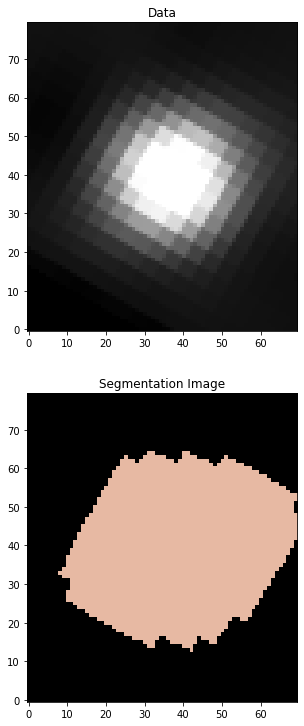

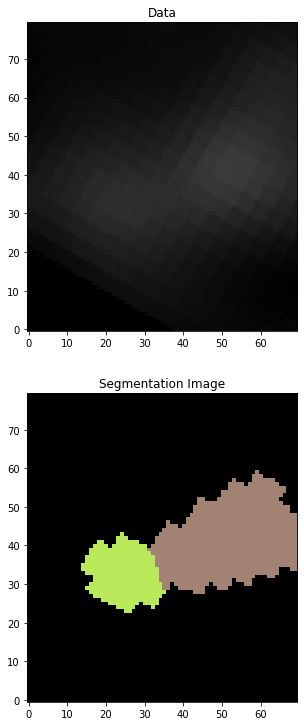

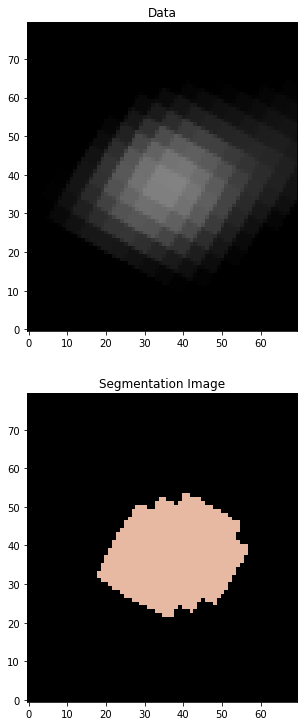

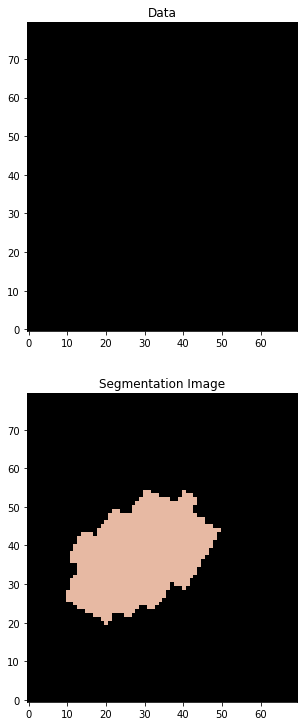

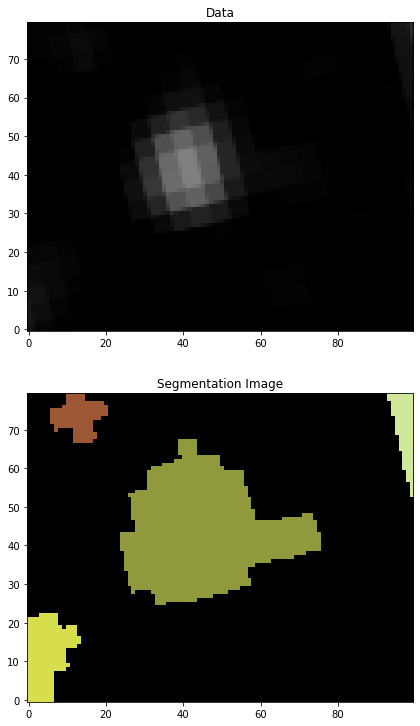

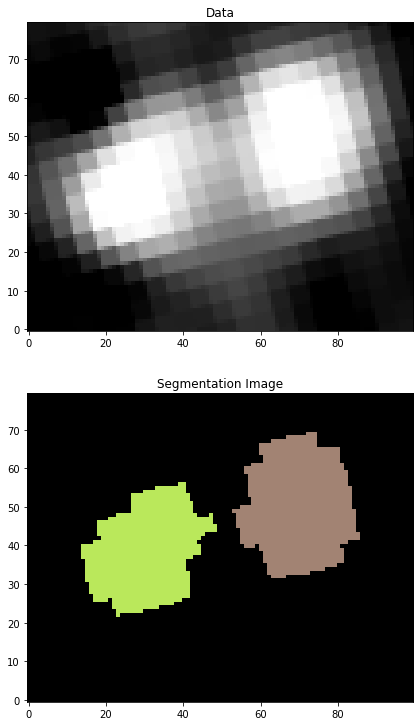

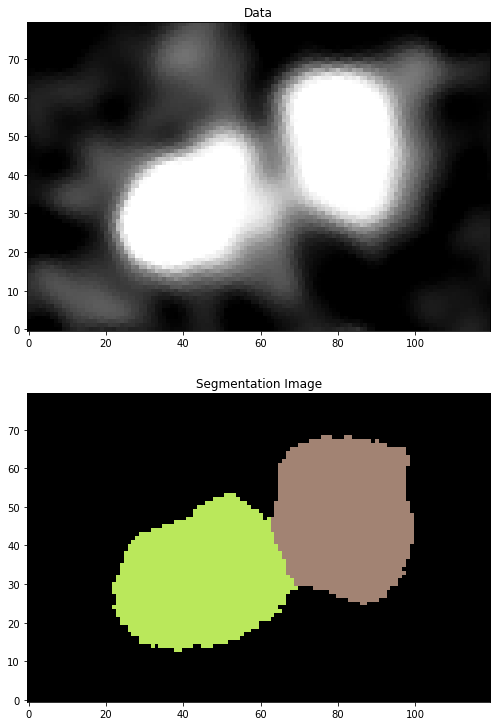

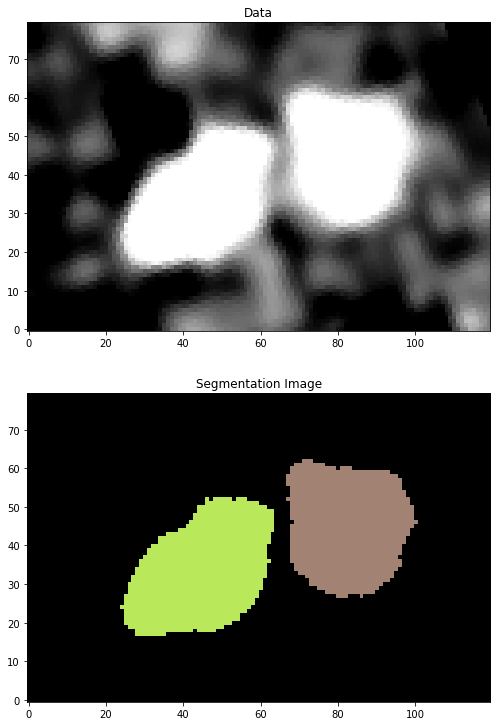

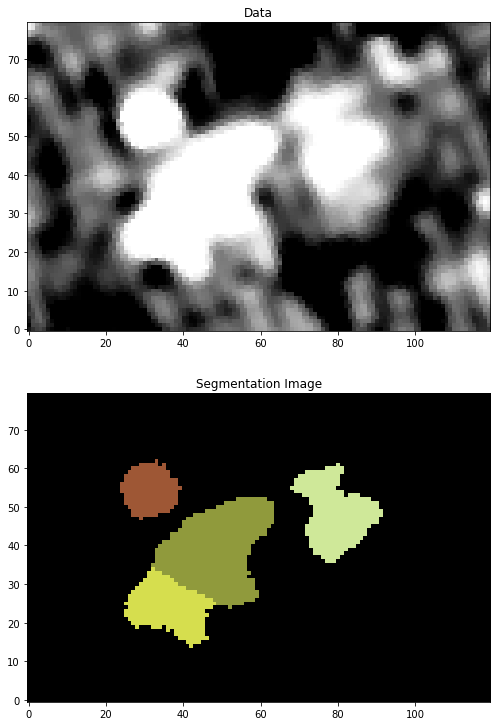

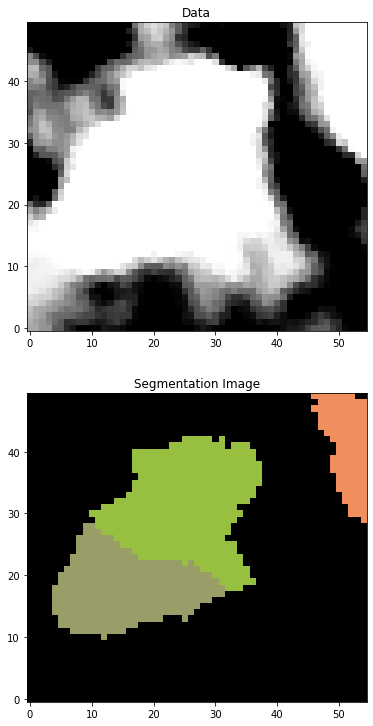

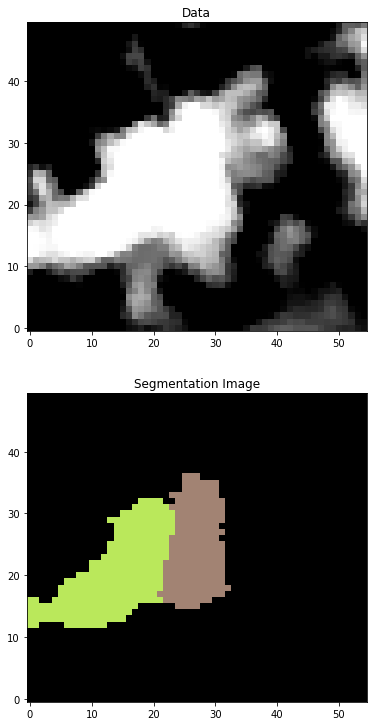

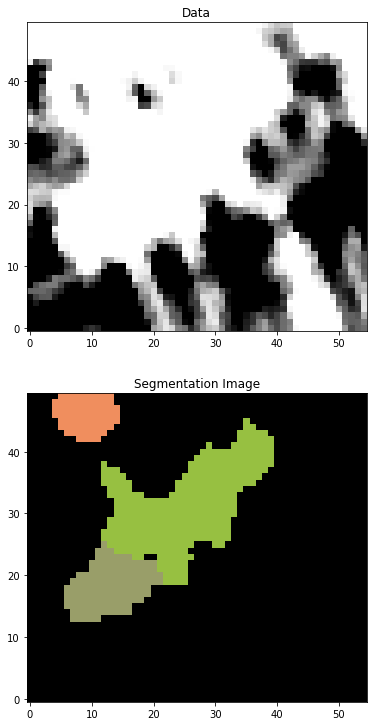

In [9]:
from photutils.segmentation import SourceCatalog
from astropy.visualization import simple_norm

#spitzer test
#please see https://photutils.readthedocs.io/en/stable/segmentation.html for references and documentation
#the idea is to use the photutils package and/or segmentation maps to distinguish a bright source from background or noise

#first step is background subtraction
bkg_estimator = MedianBackground()

bkg_list = []
data_bkg_subtracted = []
threshold_list = []
segm_deblend_list = []
# convolved_list = []


for count, img in enumerate(montage_spitz_regrid_list):
    #sorting through images of different sizes, needs different coords, need to conver to float
    if img.shape == (967, 799) and np.median(img[590:670, 250:370]) > 1e-18:
        data_cut = img[590:670, 250:370]
        nsig = 2. #IMPORTANT, should change this...
        npixels = 100
        print(count, file_list[3:][count].split('/')[-1], npixels)
    elif img.shape == (884, 768):
        data_cut = img[540:590, 245:300]
        nsig = 1. #IMPORTANT, should change this...
        npixels = 50
        print(count, file_list[3:][count].split('/')[-1], npixels)        
    elif img.shape == (748, 726) or np.median(img[590:670, 250:370]) > 1e-18:
        data_cut = img[500:580, 190:260]
        nsig = 1. #IMPORTANT, should change this...
        npixels = 10
        print(count, file_list[3:][count].split('/')[-1], npixels)
    elif img.shape == (1568, 1321):
        data_cut = img[860:940, 380:480]
        nsig = 1.
        npixels = 50
        print(count, file_list[3:][count].split('/')[-1], npixels)
    else:
        print(count, file_list[3:][count].split('/')[-1], 'not right size for img or non-detection')
        data_bkg_subtracted.append([np.nan])
        threshold_list.append([np.nan])
        continue
    
    bkg = Background2D(data_cut, (5, 5), filter_size=(3, 3), bkg_estimator=bkg_estimator)
    bkg_list.append(bkg)
    #     threshold_list.append(2. * bkg.background_rms )  # above the background
    threshold_list.append( detect_threshold(data_cut, nsigma=nsig) )
    data_bkg_subtracted.append( data_cut ) #- bkg.background ) # subtract the background

    sigma = nsig * gaussian_fwhm_to_sigma  # FWHM = whatever number is in front
    kernel = Gaussian2DKernel(sigma, x_size=nsig, y_size=nsig)
    kernel.normalize()

    
# convolved_list = []
cat_list = []
#this loop is here in case we may want to eventually loop through coordinates...
for (data,threshold) in zip(data_bkg_subtracted, threshold_list):
    if len(data) != 1:

    #     convolved_list.append( convolve(data, kernel, normalize_kernel=True) )
        segm = detect_sources(data, threshold, npixels=npixels)
        segm_deblend = deblend_sources(data, segm, npixels=npixels, nlevels=32, contrast=1e-3)
        segm_deblend_list.append( segm_deblend )

        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
        ax1.set_title('Data')
        ax2.set_title('Segmentation Image')

        norm = simple_norm(data, 'sqrt')
        ax1.imshow(np.flip(data, axis=0), origin='lower', cmap='Greys_r', vmin=1e-19, vmax=1e-17)

        cmap = segm_deblend.make_cmap(seed=123)
        ax2.imshow(np.flip(segm_deblend, axis=0), origin='lower', cmap=cmap, interpolation='nearest')
    else:
        segm_deblend_list.append(np.nan)

In [ ]:
#sorting through the different segments by hand to eliminate any unnecessary ones

for i in range(len(segm_deblend_list[4].labels)):
    label_val = segm_deblend_list[4].labels[i]
    
    if len(segm_deblend_list[4].labels) == 3:
    
        if label_val == 1:
            cmap_choice = 'Greys'

        else:
            cmap_choice = 'Oranges'

        print(label_val, cmap_choice)

    if len(segm_deblend_list[4].labels) == 4:
    
        if label_val != 3:
            cmap_choice = 'Greys'

        else:
            cmap_choice = 'Oranges'

        print(label_val, cmap_choice)
        
    segm_nparr = np.array(segm_deblend_list[4])
    segm_nparr[segm_nparr != label_val] = 0
    data_masked = np.ma.masked_array(data_bkg_subtracted[4], mask=segm_nparr)
    mask=np.ma.getmask(data_masked)
    data_masked = np.ma.masked_array(data_bkg_subtracted[4], mask=~mask)
    
    im = plt.imshow(np.flip(data_masked, axis=0), cmap=cmap_choice)

In [ ]:
#sorting through the different segments by hand to eliminate any unnecessary ones

for i in range(len(segm_deblend_list[-4].labels)):
    label_val = segm_deblend_list[-4].labels[i]
    
    if len(segm_deblend_list[-4].labels) == 3:
    
        if label_val == 1:
            cmap_choice = 'Greys'

        else:
            cmap_choice = 'Oranges'

        print(label_val, cmap_choice)

    if len(segm_deblend_list[-4].labels) == 4:
    
        if label_val == 1:
            cmap_choice = 'Greys'

        else:
            cmap_choice = 'Oranges'

        print(label_val, cmap_choice)
        
    segm_nparr = np.array(segm_deblend_list[-4])
    segm_nparr[segm_nparr != label_val] = 0
    data_masked = np.ma.masked_array(data_bkg_subtracted[-4], mask=segm_nparr)
    mask=np.ma.getmask(data_masked)
    data_masked = np.ma.masked_array(data_bkg_subtracted[-4], mask=~mask)
    
    im = plt.imshow(np.flip(data_masked, axis=0), cmap=cmap_choice)

In [41]:
#use xshift and yshift to get a desired region of the image that seems noisy and the same size our HH object zoomed-in image
data_ind = 4
xshift=0
yshift=-60

img = montage_spitz_regrid_list[data_ind]

print(montage_spitz_regrid_list[data_ind].shape)
if montage_spitz_regrid_list[data_ind].shape == (967, 799):
    data_cut = img[590+yshift:670+yshift, 250+xshift:370+xshift]
elif montage_spitz_regrid_list[data_ind].shape == (884, 768):
    data_cut = img[540+yshift:590+yshift, 245+xshift:300+xshift]
elif montage_spitz_regrid_list[data_ind].shape == (748, 726):
    data_cut = img[500+yshift:580+yshift, 190+xshift:260+xshift]
elif montage_spitz_regrid_list[data_ind].shape == (1568, 1321):
    data_cut = img[860+yshift:940+yshift, 380+xshift:480+xshift]

print(np.sum(data_cut))

# plotting the mask for reference to check it's in the right place and not too bright
# data_masked = np.ma.masked_array(hdu_data_list[data_ind][2900+xshift:3200+xshift, 4700+yshift:5100+yshift], mask=segm_nparr)
# mask=np.ma.getmask(data_masked)
# data_masked = np.ma.masked_array(hdu_data_list[data_ind][2900+xshift:3200+xshift, 4700+yshift:5100+yshift], mask=~mask)
# plt.imshow(np.flip(data_masked, axis=0))

(1568, 1321)
-1.869312757317505e-16


In [42]:
#purpose of this cell is to deal with HH object fluxes and uncertainties

#for hh6, refer to http://articles.adsabs.harvard.edu/pdf/1991ApJ...371..237C for aperture examples (fig. 5)

#possibly could do EDFs, possibly dividing the hubble images to determine extinction...maybe should do separately?
#if you want to divide two of the data files, can do so like
#data_ratio = np.divide(array, hdu1_conv_scaled, out=np.zeros_like(array), where=hdu1_conv_scaled!=0) #need to do np.divide to guarantee we get no divide by zero issue...

#matching wavelengths and lines we have...will work as row names
df = pd.read_excel('imglams.xlsx')
cols = df.columns
cols_str = [str(i) for i in df[cols[0]]]

lam_list = []
line_list = []
for name in file_list[3:]:
    #this finds the loc in the excel file where the image substring matches our image name
    #it then finds the wavelength value corresponding to that loc
    line =  df.loc[np.where([i in name for i in cols_str])[0][0]].values[0] #lambda in microns
    lam =  df.loc[np.where([i in name for i in cols_str])[0][0]].values[1] #lambda in microns
    
    #this is just to clean up the strings before appending
    if name.find('n1333_') != -1:
        line_list.append(line.split('n1333_')[-1])
    else:
        line_list.append(line)
    lam_list.append(lam)

#setting up a pandas table to be saved as excel (will store fluxes for the fitting code)
#pandas used because easy to sort and save
column_names = ['Lines', 'Lambda'] #columns
for label in segm_deblend_list[-4].labels:
    if label < 8:
        column_names.append('Knot'+str(label))

#creating dataframe and filling in the first two columns from the lists we just made
df_signal = pd.DataFrame(columns = column_names)
df_signal['Lines'] = line_list
df_signal['Lambda'] = lam_list

df_uncert = pd.DataFrame.copy(df_signal) #copying an extra one to be used for uncertainties


#looping through images (wavelengths)
xshift=0
yshift=-60 #this shift is used to capture a section of noise...hopefully works for most images
for j in range(len(data_bkg_subtracted)):
    #no convolution needed, we're just looking at all the images together
    wcs_header = hdu_header_list[j]
    hdu_signal = data_bkg_subtracted[j]
    
    #sorting through options for background, need to get a new cutout...
    if montage_spitz_regrid_list[j].shape == (967, 799):
        hdu_noise = img[590+yshift:670+yshift, 250+xshift:370+xshift]
    elif montage_spitz_regrid_list[j].shape == (884, 768):
        hdu_noise = img[540+yshift:590+yshift, 245+xshift:300+xshift]
    elif montage_spitz_regrid_list[j].shape == (748, 726):
        hdu_noise = img[500+yshift:580+yshift, 190+xshift:260+xshift]
    elif montage_spitz_regrid_list[j].shape == (1568, 1321):
        hdu_noise = img[860+yshift:940+yshift, 380+xshift:480+xshift]
    
    #looping through segments for a particular image, HH object and analyzing stats
    if len(hdu_signal) != 1:
        for i in range(len(segm_deblend_list[j].labels)):
            label_val = segm_deblend_list[j].labels[i]

            #remember to exclude some irrelevant segments
            if len(segm_deblend_list[j].labels) < 3: #this condition applies to maps with only 3 segments
                segm_nparr = np.array(segm_deblend_list[j])
                segm_nparr[segm_nparr != label_val] = 0

                #for signal 
                data_masked_signal = np.ma.masked_array(hdu_signal, mask=segm_nparr)
                mask=np.ma.getmask(data_masked_signal)
                data_masked_signal = np.ma.masked_array(hdu_signal, mask=~mask)

                knot_flux =  np.sum(data_masked_signal)

                # and now for background..
                data_masked_noise = np.ma.masked_array(hdu_noise, mask=segm_nparr)
                mask=np.ma.getmask(data_masked_noise)
                data_masked_noise = np.ma.masked_array(hdu_noise, mask=~mask)

                uncert_flux = np.sqrt(  (0.05*np.sqrt(len(data_masked_signal)) * 1e6 * 1e-23 * spitz_bw_conversion[j] * hdu_pixtorad_list[j]**2.)**2.
                                  + len(data_masked_noise) * np.std(data_masked_noise, ddof=1)**2.) #the std per pixel using N-1 and scaling by Npix?

                print("S/N: ", knot_flux, knot_flux/uncert_flux)

                #saving fluxes and uncertainties to a table to be saved
                df_signal['Knot'+str(label_val)].at[j] = knot_flux
                df_uncert['Knot'+str(label_val)].at[j] = uncert_flux
            
            elif i == 4 and label_val == 3: #this condition applies to a map with 4 segments but only 1 is the HH object
                segm_nparr = np.array(segm_deblend_list[j])
                segm_nparr[segm_nparr != label_val] = 0

                #for signal 
                data_masked_signal = np.ma.masked_array(hdu_signal, mask=segm_nparr)
                mask=np.ma.getmask(data_masked_signal)
                data_masked_signal = np.ma.masked_array(hdu_signal, mask=~mask)

                knot_flux =  np.sum(data_masked_signal)

                # and now for background..
                data_masked_noise = np.ma.masked_array(hdu_noise, mask=segm_nparr)
                mask=np.ma.getmask(data_masked_noise)
                data_masked_noise = np.ma.masked_array(hdu_noise, mask=~mask)

                uncert_flux = np.sqrt(  (0.05*np.sqrt(len(data_masked_signal)) * 1e6 * 1e-23 * spitz_bw_conversion[j] * hdu_pixtorad_list[j]**2.)**2.
                                      + len(data_masked_noise) * np.std(data_masked_noise, ddof=1)**2.) #the std per pixel using N-1 and scaling by Npix?

                print("S/N: ", knot_flux, knot_flux/uncert_flux)

                #saving fluxes and uncertainties to a table to be saved
                df_signal['Knot'+str(label_val)].at[j] = knot_flux
                df_uncert['Knot'+str(label_val)].at[j] = uncert_flux                
            
            elif label_val != 2: #for all other segment maps, they're similar with 4 total segments w the 2nd being irrelevant
                segm_nparr = np.array(segm_deblend_list[j])
                segm_nparr[segm_nparr != label_val] = 0

                #for signal 
                data_masked_signal = np.ma.masked_array(hdu_signal, mask=segm_nparr)
                mask=np.ma.getmask(data_masked_signal)
                data_masked_signal = np.ma.masked_array(hdu_signal, mask=~mask)

                knot_flux =  np.sum(data_masked_signal)

                # and now for background..
                data_masked_noise = np.ma.masked_array(hdu_noise, mask=segm_nparr)
                mask=np.ma.getmask(data_masked_noise)
                data_masked_noise = np.ma.masked_array(hdu_noise, mask=~mask)

                uncert_flux = np.sqrt(  (0.05*np.sqrt(len(data_masked_signal)) * 1e6 * 1e-23 * spitz_bw_conversion[j] * hdu_pixtorad_list[j]**2.)**2.
                                      + len(data_masked_noise) * np.std(data_masked_noise, ddof=1)**2.) #the std per pixel using N-1 and scaling by Npix?

                print("S/N: ", knot_flux, knot_flux/uncert_flux)

                #saving fluxes and uncertainties to a table to be saved
                df_signal['Knot'+str(label_val)].at[j] = knot_flux
                df_uncert['Knot'+str(label_val)].at[j] = uncert_flux
    else:
        df_signal['Knot'+str(label_val)].at[j] = np.nan
        df_uncert['Knot'+str(label_val)].at[j] = np.nan

# print(df.sort_values(by=['Lambda'], ascending=True)) #if you want to sort by wavelength from low to high lambdas
print(df_signal)
print(df_uncert)

#saving as excel file for use in future codes, make sure to update savepaths
# !conda install --yes --prefix {sys.prefix} openpyxl #may need...IF FIRST TIME DOING THIS/don't have package - takes multiple minutes
excel_savepath = '../../../Model Code and Observations/HH6_Adam/Dered_FluxesFinal.xlsx'
df_signal.to_excel(excel_savepath, index=False)
print('saved signal!')

excel_savepath = '../../../Model Code and Observations/HH6_Adam/Dered_UncertsFinal.xlsx'
df_uncert.to_excel(excel_savepath, index=False)
print('saved uncert!')


S/N:  9.9217412686475e-15 --
S/N:  1.3040386807898602e-15 12.421074712400234
S/N:  4.462202364495516e-16 4.25084227718597
S/N:  2.469208789936201e-15 21.69786706959837
S/N:  -4.857068354090421e-16 --
S/N:  4.5161409324808585e-17 0.20137489077985216
S/N:  1.720669502043067e-15 7.672254028695515
S/N:  9.968323596217723e-17 0.44448573136851033
S/N:  8.279785296815316e-15 42.93835521001196
S/N:  7.380378275564414e-15 38.2737829186132
S/N:  1.4198161667276e-14 38.22502758522688
S/N:  1.6582721549015837e-14 44.64304591217441
S/N:  1.5427174859270775e-14 312.2771909149636
S/N:  2.2084112064897113e-14 445.779501223331
S/N:  8.209824879821473e-15 165.80427415085032
S/N:  9.77653398360866e-15 197.27317007261695
S/N:  5.154077334658744e-15 104.09228911083572
S/N:  2.5961131919414144e-15 79.21160437906774
S/N:  1.1491178958167012e-14 350.0394961072059
S/N:  2.589944878368095e-15 4.495192132795509
S/N:  4.055358455725435e-15 7.038575636795681
S/N:  5.952408138525563e-15 14.466709206482744
S/N:  6.0

<ipython-input-42-ed14ef11b14d>:87: RuntimeWarning: divide by zero encountered in true_divide
  print("S/N: ", knot_flux, knot_flux/uncert_flux)
